## Exercise/TA session 14
__In this session, we are...__ 
* continuing experiments with the LDA model for spam detection in a SMS dataset. We are building and experimenting with adjustments to the code posted as lecture 13.1.ipynb to see what impact design choices regarding stopwords etc may have on the model. We also plot in 3d with matplotlib, and use a colormap to color based on lda_score
    * A text cell such as this highlights every change/addition made. 
    * The experiments illustrate an important point in any analytics approach: One should always experiment to find or even develop models that are best suited for the task at hand. 

__and...__

* trying the same approach on another type of data, first training it on (very few) news items covering two topics, to distinguish between the two. Then applying the trained model on similar news item selection to see whether it manages to distinguish.

In [1]:
# import sms-spam.csv
import numpy as np
import pandas as pd

In [2]:
sms = pd.read_csv('sms-spam.csv',usecols= ['spam','text'])
print(sms.head())

   spam                                               text
0     0  Go until jurong point, crazy.. Available only ...
1     0                      Ok lar... Joking wif u oni...
2     1  Free entry in 2 a wkly comp to win FA Cup fina...
3     0  U dun say so early hor... U c already then say...
4     0  Nah I don't think he goes to usf, he lives aro...


In [3]:
index = ['sms{}{}'.format(i, '!'*j) for (i,j) in zip(range(len(sms)), sms.spam)]
print(index[:10])# <2>

['sms0', 'sms1', 'sms2!', 'sms3', 'sms4', 'sms5!', 'sms6', 'sms7', 'sms8!', 'sms9!']


In [4]:
mask = sms.spam.astype(bool).values

In [5]:
mask

array([False, False,  True, ..., False, False, False])

### Addition: Testing stopword removal
I wanted to try the same LDA model/approach while also adding stopword removal, to see what effects that had on the accuracy. Thus I created a preprocessing function with the type of processing I wanted to try.

In [6]:
def preprocessing(corpus): #same as previous sessions
    """ (same as above, but: ) takes a list of strings (corpus of documents), 
    do preprocessing on each one, return list of preprocessed corpus
    """
    
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    stopwords = stopwords.words('english') #getting the english stop words list from NLTK
    corpusTokens = [word_tokenize(item) for item in corpus]
    
    corpusTokens = [ [word.strip().lower() 
                      for word in item if word.isalnum() and 
                      word not in stopwords] 
               for item in corpusTokens]
    
    corpusNonstop = [(' ').join(document) for document in corpusTokens]
    return corpusTokens, corpusNonstop

In [7]:
smsTokens, smsNonstop = preprocessing(sms.text)

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize.casual import casual_tokenize

### Addition: Creating TFIDF reps for both models

In [9]:
tfidf_model = TfidfVectorizer(tokenizer=casual_tokenize)#
tfidf_model1= TfidfVectorizer(tokenizer=casual_tokenize)
tfidf_docs  = tfidf_model1.fit_transform(raw_documents=sms.text).toarray()
tfidf_docs1 = tfidf_model.fit_transform(raw_documents=smsNonstop).toarray()

### Addition: computing centroids for both models

In [10]:
# Use LDA model in sklearn.discriminant_analysis.LinearDiscriminant- Analysis.
# Before applying, need to compute the centroids of binary class (spam and nonspam)
mask = sms.spam.astype(bool).values

spam_centroid = tfidf_docs[mask].mean(axis=0) # <2>
nonspam_centroid = tfidf_docs[~mask].mean(axis=0)

spam_centroid1 = tfidf_docs1[mask].mean(axis=0) # <2>
nonspam_centroid1 = tfidf_docs1[~mask].mean(axis=0)


spamminess_score = tfidf_docs.dot(spam_centroid - nonspam_centroid)
spamminess_score1 = tfidf_docs1.dot(spam_centroid1 - nonspam_centroid1)


#acc = # number of correctly predicted / # of total test samples

### Addition: Scaling both model's LDA results

In [11]:
# Transform features by scaling each feature to a given range.
from sklearn.preprocessing import MinMaxScaler
sms['lda_score'] = MinMaxScaler().fit_transform(spamminess_score.reshape(-1,1))
sms['lda_score1']= MinMaxScaler().fit_transform(spamminess_score1.reshape(-1,1))

### Addition: Tried various spam thresholds. Higher threshold of 0.9 would also fit fairly well with the test data. In a real case, false positives may arguably be significantly worse than false negatives, suggesting use of higher threshold  than 0.5

In [12]:
sms['lda_predict'] = (sms.lda_score > .9).astype(int)
sms['lda_predict1'] = (sms.lda_score1 > .9).astype(int)

### Addition: Checking how the models fits for the training data ( spam threshold at 0,9). Note better fit without stopword removal, at least for threshold of 0.5  

In [13]:
accuracy = (
    sum(
    [int(sms.loc[row,'lda_predict']==sms.loc[row,'spam']) for row in range(sms.shape[0])])
    / sms.shape[0] )
accuracy1 = (
    sum(
    [int(sms.loc[row,'lda_predict1']==sms.loc[row,'spam']) for row in range(sms.shape[0])])
    / sms.shape[0] )
print(accuracy)
print(accuracy1)

0.8786437874715732
0.8714078974571015


### Addition: Printing test data results for both models

In [14]:
# output the results
sms['spam lda_predict lda_score lda_predict1 lda_score1'.split()].round(2).head(3)

,spam,lda_predict,lda_score,lda_predict1,lda_score1
0,0,0,0.23,0,0.31
1,0,0,0.18,0,0.29
2,1,0,0.72,0,0.74


### Addition: Plotting in 3D with mpl_toolkits.mplot3d and using matplotlib colormap to illustrate LDA scores

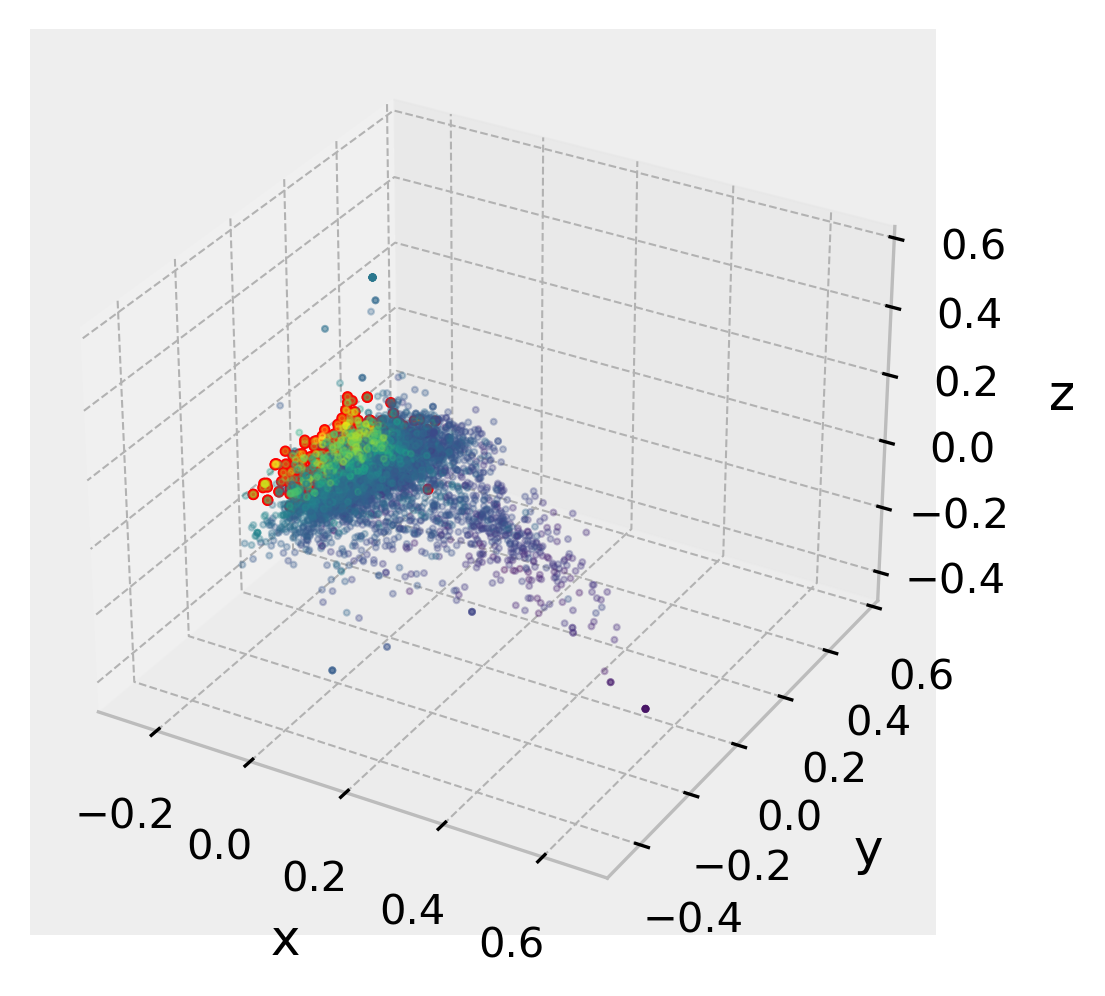

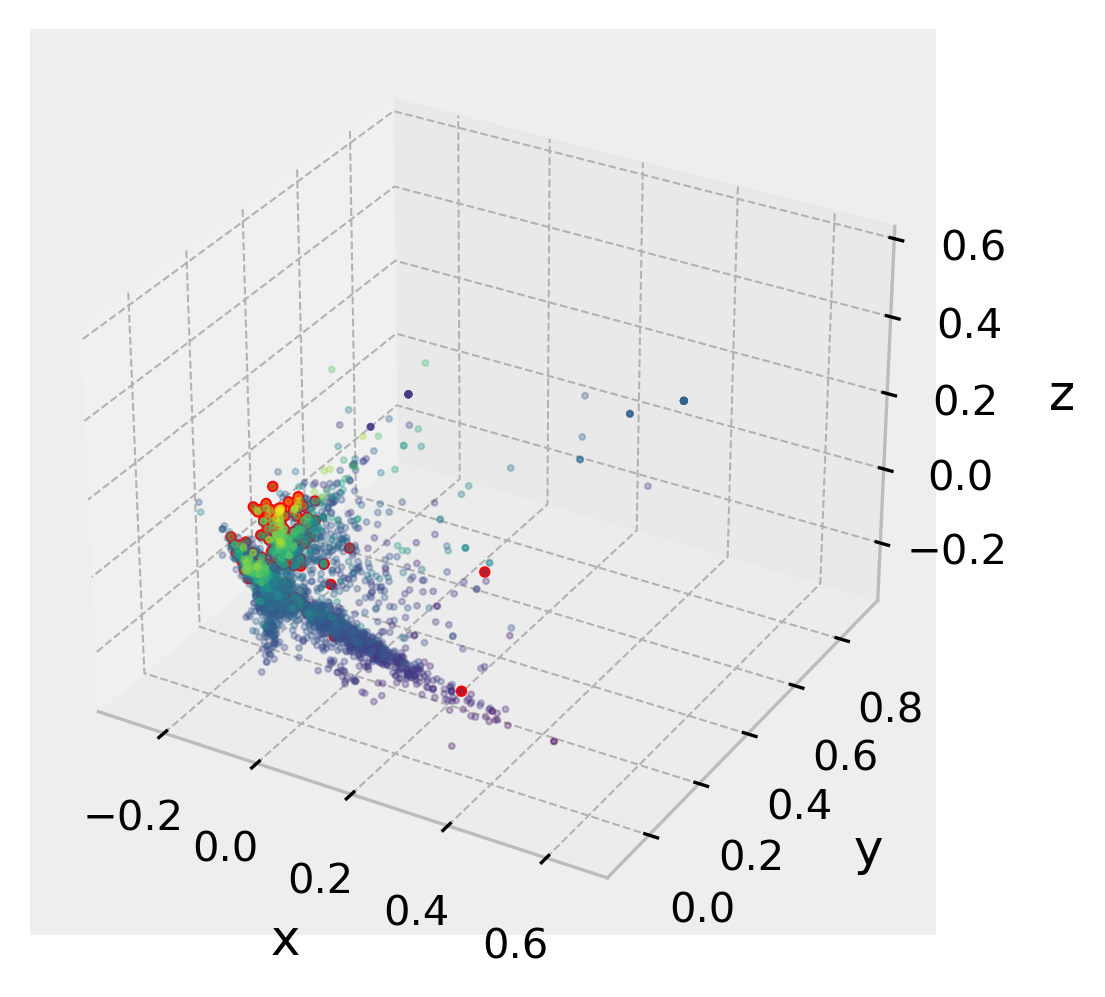

In [15]:
# visualization
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('bmh')
from matplotlib import cm
viridis = cm.get_cmap('viridis')

#pca_model = IncrementalPCA(n_components=2)
pca_model = PCA(n_components=3)
tfidf_docs_decomp = pca_model.fit_transform(tfidf_docs)
tfidf_docs_decomp1= pca_model.fit_transform(tfidf_docs1)
df = pd.DataFrame(tfidf_docs_decomp)
df['lda_score'] = sms.lda_score

df1 = pd.DataFrame(tfidf_docs_decomp1)
df1['lda_score'] = sms.lda_score1
#init 3D

fig = plt.figure(figsize=(8,4),dpi=300)
spam = fig.add_subplot(111, projection='3d')

spam.scatter(df[0], df[1], df[2], s=2, alpha=.3, c=viridis(df['lda_score']))
#spam.scatter(df[~mask][0], df[~mask][1], df[~mask][2], s=2, alpha=.3, c='green')
spam.scatter(df[mask][0], df[mask][1], df[mask][2], s=5, alpha=1, c='red',marker='o')

spam.set_xlabel(' x')
spam.set_ylabel(' y')
spam.set_zlabel(' z')

fig = plt.figure(figsize=(8,4),dpi=300)
spam1 = fig.add_subplot(111,projection='3d')


spam1.scatter(df1[0], df1[1], df1[2], s=2, alpha=.3, c=viridis(df1['lda_score']))
#spam1.scatter(df1[~mask][0], df1[~mask][1], df1[~mask][2], s=2, alpha=.3, c='green')
spam1.scatter(df1[mask][0], df1[mask][1], df1[mask][2], s=5, alpha=1, c='red',marker='o')


spam1.set_xlabel(' x')
spam1.set_ylabel(' y')
spam1.set_zlabel(' z')
plt.show()
#plt.savefig('spam_lda_3d_scatter.png')

### Addition: Examining how a colormap works. it takes values between 0 and 1 and return RGB and Alpha channel values describing the color

In [16]:
for i in range(10):
    print(viridis(i/10))

(0.267004, 0.004874, 0.329415, 1.0)
(0.282623, 0.140926, 0.457517, 1.0)
(0.253935, 0.265254, 0.529983, 1.0)
(0.206756, 0.371758, 0.553117, 1.0)
(0.163625, 0.471133, 0.558148, 1.0)
(0.127568, 0.566949, 0.550556, 1.0)
(0.134692, 0.658636, 0.517649, 1.0)
(0.266941, 0.748751, 0.440573, 1.0)
(0.477504, 0.821444, 0.318195, 1.0)
(0.741388, 0.873449, 0.149561, 1.0)


# The following is an application of the above type of boolean classification
### The boolean LDA type classification is used as an example simply not to introduce other clustering algorithms at this point, although it would not be suitable for this type of task in a real application

## Training the model

In [17]:
#file to train TF-IDF and boolean LDA model on (contains manual labelling for training)
path = '../../../../Data Management/AC track data/2021-10-27 News items on space and data unsorted.csv'

#file to test the trained model on (no labelling)
path2= '../../../../Data Management/AC track data/2021-10-27 News items on space2.csv'

In [18]:
import numpy as np
import pandas as pd

In [19]:
#loading training set
trainingSet = pd.read_csv(path, usecols=['string','category'])
trainingSet.head()

,string,category
0,NASA now aims to launch massive next-generatio...,space
1,NASA plans to launch Artemis I Moon mission in...,space
2,The Morning After: NASA sets a new date for it...,space
3,SpaceX needs to tame toilet trouble before wee...,space
4,S.Korea prepares to launch first domestically ...,space


In [20]:
mask = (trainingSet.category=='space').values 
mask

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True, False,  True,  True, False,
        True, False])

In [21]:
#defining the preprocessing
def preprocessing(corpus): #similar to previous sessions
    """ (same as above, but: ) takes a list of strings (corpus of documents), 
    do preprocessing on each one, return list of preprocessed corpus
    """
    
    from nltk import word_tokenize
    from nltk.corpus import stopwords
    stopwords = stopwords.words('english') #getting the english stop words list from NLTK
    corpusTokens = [word_tokenize(item) for item in corpus]
    
    corpusTokens = [ [word.strip().lower() 
                      for word in item if word.isalnum() and 
                      word not in stopwords] 
               for item in corpusTokens]
    
    corpusNonstop = [(' ').join(document) for document in corpusTokens] #added this step
    return corpusTokens, corpusNonstop #note output two result types, in tokens, and "sentences"

In [22]:
#running preprocessing on training set
trainingSetTokens, trainingSetNonstop = preprocessing(trainingSet.string)

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

tfidf_trained = TfidfVectorizer()
tfidf_trainingSet = tfidf_trained.fit_transform(trainingSetNonstop).toarray()

#getting the vocabulary that has been created from the training set 
#(the same vocabulary must be used for to create TF-IDF reps for the
#test data as well (otherwise new training would need to be conducted)
#on the complete set including new items. That is sometimes possible,
#but if you receive lots of new data all the time and the total amount
#of data is large, it might be too computationally intensive.
vocabulary_trained = tfidf_trained.vocabulary_


#computing centroids for the two topics in the training set, based on mask
topic1_centroid_trained = tfidf_trainingSet[mask].mean(axis=0)
topic2_centroid_trained = tfidf_trainingSet[~mask].mean(axis=0)
topic_scores_training = tfidf_trainingSet.dot(topic1_centroid_trained - topic2_centroid_trained)

trainingSet['lda_score'] = MinMaxScaler().fit_transform(topic_scores_training.reshape(-1,1))

In [24]:
trainingSet.head(2)

,string,category,lda_score
0,NASA now aims to launch massive next-generatio...,space,0.996753
1,NASA plans to launch Artemis I Moon mission in...,space,0.987944


In [25]:
trainingSet['lda_space_or_data_predict'] = ['space' if (trainingSet.lda_score[row] > 0.5)  else 'data'
                             for row in range(trainingSet.shape[0])]
accuracy = (
    sum(
    [int(trainingSet.loc[row,'lda_space_or_data_predict']==trainingSet.loc[row,'category']) 
         for row in range(trainingSet.shape[0])])
    / trainingSet.shape[0] )
print('accuracy (on training set):',accuracy)
trainingSet.tail(3)

accuracy (on training set): 1.0


,string,category,lda_score,lda_space_or_data_predict
17,Amazon offers up more data to tell third-party...,data,0.035805,data
18,"She Is Breaking Glass Ceilings in Space, but F...",space,0.774975,space
19,Senior industry leaders need to learn about AI...,data,0.098095,data


## Now the model has been trained (on a mere 20 documents), and is ready to attempt to classify new items

In [26]:
#getting the test set
testSet = pd.read_csv(path2, usecols=['string'])
testSet['category']=[None]*testSet.shape[0]
testSet.head()

,string,category
0,Jett: The Far Shore Imagines Conscientious Spa...,None
1,How Wavelets Let Researchers Transform and Und...,None
2,Will Data Science be in Demand in the Future?:...,None
3,William Shatner becomes the oldest person to r...,None
4,Missouri Governor Wants to Prosecute Journalis...,None


In [27]:
testSetTokens, testSetNonstop = preprocessing(testSet.string)

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler

tfidf_trained = TfidfVectorizer(vocabulary=vocabulary_trained) #we are using the same vocabulary as 
                                                            #previously, meaning we ignore words not
                                                            #in previous vocabulary
tfidf_testSet = tfidf_trained.fit_transform(testSetNonstop).toarray()

#and we are using the same centroids as they are created by previous training
topic_scores_test = tfidf_testSet.dot(topic1_centroid_trained - topic2_centroid_trained)

testSet['lda_score'] = MinMaxScaler().fit_transform(topic_scores_test.reshape(-1,1))
testSet['lda_space_or_data_predict'] = ['space' if (testSet.lda_score[row] > 0.5) else 'data'
                             for row in range(testSet.shape[0])]
testSet.head(2)

,string,category,lda_score,lda_space_or_data_predict
0,Jett: The Far Shore Imagines Conscientious Spa...,None,0.756755,space
1,How Wavelets Let Researchers Transform and Und...,None,0.000000,data


## Examining results
The model's performance is quite poor compared to human resoning. Still, it is somewhat able to distinguish these two (boolean, and quite different) topics, although with some false positives that may be news articles not belonging in any of the topics, and other errors. This could arguably be improved by having the results labeled as "unassigned" if the model score is not certain enough. Such a modification could be done by adjusting the certainty threshold required to classify an item (from currently above or below 0.5, to a criteria in the ranges of [0, 0.2] and [0.8, 1]). In this case, this would yield too many unassigned items. 

A probable cause for poor performance is that the training set consists of only 20 items, with most of them being about space related issues, and only a small handfull about data science. With only 20 items, the TF-IDF vocabulary becomes limited, impacting the model's ability to deal with new items using different words. 

In these experiments, the model fed only with items having the keywords data science or the keyword space. A true classifier of unstructured text items of unknown types would need to cluster/classify in several groups, of course depending on the data feed and the desired outcomes.

In [29]:
for row in range(testSet.shape[0]):
    #if testSet.loc[row,'lda_score'] > 0.7 or testSet.loc[row,'lda_score'] < 0.3:
    print('----------------')
    print(testSet.loc[row,'lda_space_or_data_predict'])
    print(testSet.loc[row,'lda_score'])
    print(testSet.loc[row,'string'])
    print('----------------\n\n')
    #else:
    #    print('----------------')
    #    print('unassigned')
    #    print(testSet.loc[row,'string'])
    #    print('----------------\n\n')

----------------
space
0.7567553122137926
Jett: The Far Shore Imagines Conscientious Space Colonization: WIRED spoke with the game's devs, plus a senior NASA astrobiologist, about the game and its vision of interstellar environmentalism.: Ahead of you is a vast pink sky and a teeming alien planet. Your copilot, Isao, asks you to cut the aircrafts engine. He wants to savor this moment: your first look at an entirely new world.
Jett: T… [+3481 chars]
----------------


----------------
data
0.0
How Wavelets Let Researchers Transform and Understand Data: Built upon the ubiquitous Fourier transform, these mathematical tools allow unprecedented analysis of continuous signals.: In an increasingly data-driven world, mathematical tools known as wavelets have become an indispensable way to analyze and understand information. Many researchers receive their data in the form of c… [+4315 chars]
----------------


----------------
data
0.42167599116011023
Will Data Science be in Demand in the Futur

In [30]:
testSet['string lda_space_or_data_predict lda_score'.split()].round(2)

,string,lda_space_or_data_predict,lda_score
0,Jett: The Far Shore Imagines Conscientious Spa...,space,0.76
1,How Wavelets Let Researchers Transform and Und...,data,0.00
2,Will Data Science be in Demand in the Future?:...,data,0.42
3,William Shatner becomes the oldest person to r...,space,0.78
4,Missouri Governor Wants to Prosecute Journalis...,data,0.49
5,Technology is Reinventing the Insurance Indust...,space,0.67
6,Pioneering astronaut Sally Ride will appear on...,space,0.75
7,11 Scary Space Facts That'll Make You Apprecia...,space,0.76
8,'Winterize' Your Outdoor Space so You Can Actu...,space,0.62
9,UK takes on Elon Musk in the broadband space r...,space,0.82
